In [1]:
!pipenv install matplotlib seaborn statsmodels "modin[ray]" sklearn h2o tensorflow "pandas-profiling[notebook]"

Installing matplotlib…
Adding matplotlib to Pipfile's [packages]…
✔ Installation Succeeded 
Installing seaborn…
Adding seaborn to Pipfile's [packages]…
✔ Installation Succeeded 
Installing statsmodels…
Adding statsmodels to Pipfile's [packages]…
✔ Installation Succeeded 
Installing modin[ray]…
Adding modin to Pipfile's [packages]…
✔ Installation Succeeded 
Installing sklearn…
Adding sklearn to Pipfile's [packages]…
✔ Installation Succeeded 
Installing h2o…
Adding h2o to Pipfile's [packages]…
✔ Installation Succeeded 
Installing tensorflow…
Adding tensorflow to Pipfile's [packages]…
✔ Installation Succeeded 
Installing pandas-profiling[notebook]…
Adding pandas-profiling to Pipfile's [packages]…
✔ Installation Succeeded 
Installing dependencies from Pipfile.lock (e36465)…
  🐍   ▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉ 0/0 — 00:00:00


In [2]:
import bz2
from datetime import datetime
import logging
import os
import platform
import time
#import tqdm
from urllib.parse import urlparse

#import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
#import numpy as np
import statsmodels as sm

from pandas_profiling import ProfileReport

os.environ["MODIN_ENGINE"] = "ray"  # Modin will be using the Ray engine
# import pandas as pd
import modin.pandas as pd

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder

import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import (H2ORandomForestEstimator,
                            H2OXGBoostEstimator)
from h2o.grid.grid_search import H2OGridSearch

import tensorflow as tf

In [3]:
python_version = platform.python_version()
tensorflow_version = tf.__version__

if python_version < '3.7':
    print("This notebook requires Python 3.7+ to run. You are running Python {}".format(python_version))
    print("Continue using at your own risk")
else:
    print("Running Python {}".format(python_version))

if tensorflow_version < '2.':
    print("This notebook requires TensorFlow 2+ to run. You are computing with TensorFlow {}".format(tensorflow_version))
    print("Results are not guaranteed to be correct. Continue using at your own risk")
else:
    print("Computing with TensorFlow {}".format(tensorflow_version))

Running Python 3.7.7
Computing with TensorFlow 2.2.0


In [4]:
%matplotlib inline
random_seed = 12345
tf.random.set_seed(random_seed)

#### Important notes...

If you have *NOT* obtained this noteboook by cloning the repository in GitHub where it is tracked, you have to download the data pointeed in the `PLAYS_URI` constant and place it in a location that you will have to adjunst in the `DATA_DIR` contanst.

However, if you have actually obtained this noteboook by cloning the repository in GitHub but moved it to some other location, you will have to adjust the `DATA_DIR` contanst to make it work.

In [5]:
# Some common variables
DATA_DIR = os.path.join(os.getcwd(), 'data')

PLAYS_URI = 'https://storage.googleapis.com/king-airnd-recruitment-sandbox-data/toydata_mltest.tar.gz'
PLAYS_FILENAME = 'game-plays.csv'
PLAYS_FILE_OPTIONS = {'id': 'string', # sample index (unique)
                      'c1': 'string', # categorical player feature
                      'c2': 'string', # categorical player feature
                      'c3': 'string', # categorical player feature
                      'c4': 'string', # categorical player feature
                      'c5': 'boolean', # categorical player feature
                      'c6': 'string', # categorical player feature
                      'player_group': 'string', # version of the experiment (A or B)
                      'n1': 'string', # engagement intensity (last 30 days before A/B test experiment)
                      'n2': 'string', # numerical player feature (collected before the test experiment)
                      'n3': 'string', # numerical player feature (collected before the test experiment)
                      'n4': 'string', # numerical player feature (collected before the test experiment)
                      'n5': 'string', # numerical player feature (collected before the test experiment)
                      'n6': 'string', # numerical player feature (collected before the test experiment)
                      'n7': 'string', # numerical player feature (collected before the test experiment)
                      'n8': 'string', # numerical player feature (collected before the test experiment)
                      'n9': 'string', # numerical player feature (collected before the test experiment)
                      'n10': 'string', # numerical player feature (collected before the test experiment)
                      'n11': 'string', # numerical player feature (collected before the test experiment)
                      'n12': 'string', # numerical player feature (collected before the test experiment)
                      'n13': 'string', # engagement intensity (first 7 days of A/B test experiment)
                      'n14': 'string', # monetization metric (first 7 days of A/B test experiment expenditure)
                     }

In [6]:
# Some helper functions
def is_url(uri):
    return urlparse(uri).scheme in ('http', 'https',)

def str_to_date(date, format='%Y-%m-%d'):
    """
    Converts a string date in to its date type equivalent
    """
    return datetime.strptime(date, format).date()

# Taken from https://stackoverflow.com/a/51724511
class LabelEncoderByCol(BaseEstimator, TransformerMixin):

    def __init__(self, col):
        #List of column names in the DataFrame that should be encoded
        self.col = col
        #Dictionary storing a LabelEncoder for each column
        self.le_dic = {}
        for el in self.col:
            self.le_dic[el] = LabelEncoder()

    def fit(self, x, y=None):
        #Fill missing values with the string 'NaN'
        x[self.col] = x[self.col].fillna('NaN')
        for el in self.col:
            #Only use the values that are not 'NaN' to fit the Encoder
            a = x[el][x[el]!='NaN']
            self.le_dic[el].fit(a)
        return self

    def transform(self, x, y=None):
        #Fill missing values with the string 'NaN'
        print(self.col)
        x[self.col] = x[self.col].fillna('NaN')
        for el in self.col:
            #Only use the values that are not 'NaN' to fit the Encoder
            a = x[el][x[el]!='NaN']
            #Store an ndarray of the current column
            #b = x[el].get_values()
            b = x[el].to_numpy()
            #Replace the elements in the ndarray that are not 'NaN'
            #using the transformer
            b[b!='NaN'] = self.le_dic[el].transform(a)
            #Overwrite the column in the DataFrame
            x[el]=b
        #return the transformed DataFrame
        return x

def load_file(filenames, options=None, bzip2=True):
    """
    Loads the data contained in one or more files and returns it as a Pandas variable
    """
    def read_csv_as_pd(csv_path, options=None):
        if options:
            return pd.read_csv(csv_path, dtype=options)
        else:
            return pd.read_csv(csv_path)
    
    def read_bz2_as_pd(filepath, options=None):
        with bz2.open(filepath, "rt") as f:
            data = read_csv_as_pd(f, options)
            
        return data
    
    def read_gz_as_pd(filepath, options=None):
        data = None
        return data
    
    if type(filenames) is not list:
        filenames = [filenames]
    
    filenames = [filename if is_url(filename) else os.path.join(DATA_DIR, filename) for filename in filenames]
    
    if bzip2:
        filenames = [filename + '.bz2' if bzip2 else filename for filename in filenames]
        df_files_array = (read_bz2_as_pd(filename, options) for filename in filenames)
    else:
        df_files_array = (read_csv_as_pd(filename, options) for filename in filenames)

    data = pd.concat(df_files_array, ignore_index=True)
    
    return data

def save_recommendations(recommendations,
                         filename,
                         user_col='visitorid',
                         item_col_prefix='item_',
                         n=100):

    col_names = [item_col_prefix + str(x) for x in range(n)]

    data = pd.DataFrame.from_dict(recommendations, orient='index', columns=col_names)
    data.index.names = [user_col]
    data.reset_index(inplace=True)

    data.to_csv(filename, index=False)

In [7]:
# Load game plays
raw_plays = load_file(PLAYS_FILENAME, PLAYS_FILE_OPTIONS)        

To request implementation, send an email to feature_requests@modin.org.


In [8]:
raw_plays.sample(n=10)

,id,c1,c2,c3,c4,c5,c6,player_group,n1,n2,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
17783,17783,QVI,aW9z,cHQ,aHVhd,True,KzAzOjAw,B,285.435952,1017.989281,...,380.412474,2838198508.955004,7.528382,1049.380869,<NA>,0.35224,2.905315,0.000244,77.109207,0.182819
37808,37808,SVQ,aW9z,ZXM,<NA>,True,LTA1OjAw,A,190.891086,668.08519,...,256.136247,5204086018.89359,1.690974,717.068276,<NA>,0.161727,1.386565,153.918858,50.580657,0.101316
14054,14054,QVI,aW9z,cHQ,aHVhd,True,KzAzOjAw,B,282.094877,1005.525773,...,376.024579,928188957.17793,7.111751,1037.625659,39.558731,0.342566,2.837904,0.276357,76.14688,0.179337
8089,8089,RlI,YW5kc,ZW4,YXBwb,True,LTA0OjAw,A,116.412059,398.13394,...,157.759128,-0.024382,0.543172,454.343902,<NA>,0.08335,0.640747,0.011664,31.168953,0.056231
13089,13089,R0I,YW5kc,ZXM,<NA>,True,LTA0OjAw,A,145.015598,501.021254,...,195.626901,2862385628.581904,0.849568,555.698411,<NA>,0.108967,0.889655,0.103748,38.440632,0.072005
1670,1670,Uk8,aW9z,emg,bGdl,True,KzA4OjAw,B,478.270719,1745.11147,...,634.059835,1442210205.513909,406.661923,1715.383207,<NA>,2.336914,9.209436,0.037757,132.959781,0.500623
42382,42382,RVM,aW9z,ZXM,<NA>,True,LTA1OjAw,A,212.663162,748.082021,...,284.788709,1910607871.353982,2.347038,793.523517,<NA>,0.193634,1.671378,0.026975,56.532202,0.117283
27294,27294,SVI,<NA>,YXI,dml2b,True,KzAxOjAw,B,534.044608,1957.451941,...,707.698304,1567021561.553124,1513.518215,1896.371546,<NA>,5.056064,12.173558,0.004305,148.599845,0.653655
7462,7462,VVM,YW5kc,ZW4,c2Ftc,True,KzA1OjMw,A,13.016987,41.627974,...,18.761414,0.785589,0.042077,62.577854,<NA>,0.013419,0.043287,0.015848,5.896846,0.009061
14032,14032,TVg,YW5kc,ZW4,YXBwb,True,LTA0OjAw,A,129.873692,446.414274,...,175.59758,1269277625.812305,0.672634,502.163655,<NA>,0.094842,0.752616,0.191375,34.562279,0.063443


In [9]:
raw_plays.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            50000 non-null  string 
 1   c1            45054 non-null  string 
 2   c2            44943 non-null  string 
 3   c3            50000 non-null  string 
 4   c4            42445 non-null  string 
 5   c5            50000 non-null  boolean
 6   c6            44913 non-null  string 
 7   player_group  50000 non-null  string 
 8   n1            50000 non-null  string 
 9   n2            50000 non-null  string 
 10  n3            50000 non-null  string 
 11  n4            50000 non-null  string 
 12  n5            50000 non-null  string 
 13  n6            50000 non-null  string 
 14  n7            50000 non-null  string 
 15  n8            50000 non-null  string 
 16  n9            2257 non-null   string 
 17  n10           50000 non-null  string 
 18  n11           50000 n

In [10]:
raw_plays._to_pandas().describe()

,id,c1,c2,c3,c4,c5,c6,player_group,n1,n2,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
count,50000,45054,44943,50000,42445,50000,44913,50000,50000,50000,...,50000,50000,50000,50000,2257,50000,50000,50000,50000,50000
unique,50000,174,4,29,268,2,35,2,49932,49952,...,49961,49863,48136,49865,2257,45690,46673,45445,49979,42458
top,24007,SU4,YW5kc,ZW4,c2Ftc,True,KzAyOjAw,A,-0.999999,-0.999999,...,-0.999999,0.221903,0.001478,-1.0,-0.142288,inf,0.0,0.0,40.913724,0.000846
freq,1,7641,29980,26894,13891,49956,7449,35280,6,5,...,5,2,6,45,1,293,203,125,2,10


In [11]:
# Some quick profiling of the data, for the lazy ones :)
raw_plays_data=raw_plays.copy()._to_pandas()
raw_plays_profile = ProfileReport(raw_plays_data,
                                  title="A/B test plays profiling report",
                                  explorative=True)

#raw_plays_profile.widgets()
raw_plays_profile.to_notebook_iframe()

Interesting to note the correlation of some categorical columns with the 'target' column. This is likely to indicate that the behaviour of the user conveyed in the numerical columns may not be that importatnt after all. Although this is just speculation as the 'game feature' represents the 'same functionality' in either test, 'A' or 'B', hence this seems more in line with a user interface change that the user still requires or is equally aware of regardless of the test.

Another interesting note is on the uniformity distribution of all numerical columns ('n10' is also uniformly distributed but contains 'inf' values). This is valuable information when it comes to assessing the imbalanced dataset in terms of classification, i.e., 'player_group', 'A' or 'B', because rebalancing the dataset (or maybe doing nothing) will not affect such rebalancing, in the context of those numerical columns.

In [12]:
# Check 'c5' for values' count
raw_plays.groupby('c5').agg(['count']).c5

,count
c5,
False,44
True,49956


In [13]:
#  Check 'n10' for 'infinite' value counts
raw_plays[(raw_plays['n10'] == 'inf')].n10.count()

293

In [14]:
# Check number of NAs per column
raw_plays.isnull().sum(axis=0).to_frame('# NAs')

,# NAs
id,0
c1,4946
c2,5057
c3,0
c4,7555
c5,0
c6,5087
player_group,0
n1,0
n2,0


In [15]:
# Dropping 'id' field as it is useless because it is unique
raw_plays.drop('id', axis=1, inplace=True)
# Dropping 'c5' categorical column (which is a boolean though) as it has very few False values (44 vs 49956)
raw_plays.drop('c5', axis=1, inplace=True)
# Dropping 'n9' numerical column as it has very few non-NA values (2257 vs 47743)
raw_plays.drop('n9', axis=1, inplace=True)

In [16]:
# Drop the rows where column 'n10' is infinite
raw_plays = raw_plays[raw_plays.n10 != 'inf']
# Reset the index, else we will have issues later
raw_plays.reset_index(drop=True, inplace=True)

In [17]:
# Convert numerical string columns to floats
raw_plays_numerical_columns = raw_plays.filter(regex='^n\d{1,2}$').columns
for col in raw_plays_numerical_columns:
    #raw_plays[col] = raw_plays[col].astype(float)
    raw_plays[col] = pd.to_numeric(raw_plays[col], errors='coerce')

In [18]:
raw_plays

,c1,c2,c3,c4,c6,player_group,n1,n2,n3,n4,n5,n6,n7,n8,n10,n11,n12,n13,n14
0,R0I,YW5kc,ZXM,<NA>,LTA0OjAw,A,147.175163,508.833307,1.373772,4.777273,198.480790,1.513241e+09,0.877958,563.317119,0.111096,0.910215,0.270997,38.999087,0.073268
1,QVI,aW9z,cHQ,aHVhd,KzAzOjAw,B,288.359771,1028.901212,13.839420,10.323625,384.252343,7.030908e+08,7.915538,1059.667759,0.360950,2.965243,0.349473,77.952363,0.185909
2,SVQ,aW9z,ZXM,<NA>,LTA1OjAw,A,186.063223,650.402814,2.372309,4.691797,249.778061,5.050894e+09,1.573227,700.112963,0.155331,1.327952,0.140478,49.276629,0.097967
3,R0I,YW5kc,ZXM,<NA>,LTA0OjAw,A,144.562911,499.384425,0.010756,13.515655,195.028589,2.703625e+09,0.843725,554.100930,0.108525,0.885378,0.152239,38.323737,0.071742
4,QlI,YW5kc,ZW4,YXBwb,<NA>,A,77.314738,259.654122,26.709407,27.031636,105.726136,-1.728980e-01,0.274720,313.339044,0.054445,0.363698,1.058591,21.585558,0.037120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49702,R0I,YW5kc,ZXM,<NA>,LTA0OjAw,A,145.520371,502.846716,14.522330,16.519088,196.294021,2.728730e+09,0.856128,557.479510,0.109462,0.894437,0.027793,38.571046,0.072299
49703,Q0E,aW9z,ZnI,aHVhd,KzAzOjAw,A,265.792743,944.802399,0.331361,8.851814,354.613390,2.048980e+09,5.416289,980.270840,0.299305,2.524877,0.197182,71.471077,0.163053
49704,VVM,YW5kc,ZW4,c2Ftc,KzA1OjMw,A,17.169584,55.014058,317.300753,15.911628,24.484764,-2.343420e-01,0.052445,80.387571,0.016381,0.058887,0.678615,7.015246,0.010946
49705,UEU,aW9z,aXQ,bW90b,KzA4OjAw,B,441.861705,1606.896007,0.223426,2.268875,586.067364,2.170715e+09,175.055901,1593.317859,1.526828,7.591714,0.095397,122.558052,0.418659


In [19]:
# Just show some random rows for fun
raw_plays.sample(n=15)

,c1,c2,c3,c4,c6,player_group,n1,n2,n3,n4,n5,n6,n7,n8,n10,n11,n12,n13,n14
36458,SU4,YW5kc,ZW4,c2Ftc,KzAyOjAw,A,0.069393,1.841503,0.736807,29.926697,0.586335,2.220080e-01,0.008022,3.556438,-5.850000e-04,0.002160,0.000874,1.316008,0.001754
35821,SU4,YW5kc,ZW4,c2Ftc,KzAyOjAw,A,-0.982681,-0.962932,0.002780,30.815924,-0.972127,4.752380e-01,0.001178,-0.973275,-6.907000e-03,0.000018,0.067137,0.012543,0.000196
2122,SU4,YW5kc,ZW4,c2Ftc,KzAyOjAw,A,2.182189,7.953300,0.580538,1.376273,3.619769,-8.331100e-02,0.014881,13.572477,3.270000e-03,0.007649,0.001547,2.404454,0.003378
43430,Qk8,<NA>,amE,Z2lvb,KzA5OjAw,B,800.002681,2977.806703,0.950581,16.174258,1060.747813,4.392120e+09,300052.531831,2622.808149,8.980864e+04,37.761976,0.059175,218.098688,2.139678
37816,QVI,aW9z,cHQ,aHVhd,LTAzOjAw,B,296.939015,1060.945655,0.358427,23.992750,395.519457,4.038207e+09,9.186853,1089.849200,3.879070e-01,3.146219,0.515459,80.431438,0.195206
46886,QVI,aW9z,cHQ,aHVhd,KzAzOjAw,B,284.470209,1014.386061,0.006900,22.813444,379.144151,8.977766e+08,7.405207,1045.983030,3.494130e-01,2.885713,0.443582,76.830916,0.181808
49191,RVM,aW9z,ZXM,<NA>,LTA1OjAw,A,212.138147,746.148304,2.953197,19.013551,284.098133,1.755622e+09,2.328403,791.679679,1.928010e-01,1.664099,0.155768,56.387381,0.116881
27731,Tlo,aHRtb,cm8,b25lc,KzA5OjAw,B,840.382149,3133.657617,1640.812711,14.026732,1114.582253,2.467631e+09,531441.143330,2711.986889,2.718422e+06,43.964026,0.074693,228.058080,2.539875
7081,TVg,YW5kc,ZW4,YXBwb,LTA0OjAw,A,134.279839,462.273108,4.603812,30.002846,181.429550,3.290055e+09,0.720386,517.765282,9.881300e-02,0.791234,14.099364,35.684103,0.065883
11746,VEg,aW9z,ZnI,<NA>,KzAzOjAw,A,257.755373,914.921832,10.151709,25.338323,344.055781,1.811334e+09,4.750576,951.999270,2.801520e-01,2.379920,0.054701,69.179314,0.155440


### Question 1

Identify a globally better design for all players, i.e., if you would have to choose one of the two designs, A or B, for all the players, which one would you choose? Why?

##### Some answer
We have to compare the two samples with some sort of hypotheses test on the features related to the actual test, i.e., n13 and n14, and statitiscal metrics to be calculated as per the corresponding 'player_group' column.

So this seems a classical example for a 2 sample t-test statistical hypothesis, testing the same thing on two different populations.

Conveniently, from the course in statistics I did exactly 18 years ago, student t-test distribution is handy for this purpose.
If you have the statistical metrics, use this: https://www.evanmiller.org/ab-testing/t-test.html otherwise see below to know how to get them and compute the p-value and make your conclusions about the hypotheses.
Some references: https://blog.minitab.com/blog/adventures-in-statistics-2/understanding-t-tests-1-sample-2-sample-and-paired-t-tests

In [20]:
# Compute some descriptive statistics of each test, A and B.
player_group_A_n13 = raw_plays[(raw_plays.player_group == 'A')].n13
player_group_B_n13 = raw_plays[(raw_plays.player_group == 'B')].n13

player_group_A_n14 = raw_plays[(raw_plays.player_group == 'A')].n14
player_group_B_n14 = raw_plays[(raw_plays.player_group == 'B')].n14

print("Player group A - n13\n\tMean: %g\n\tStd: %g\n\tSize: %g" % (player_group_A_n13.mean(),
                                                                   player_group_A_n13.std(),
                                                                   player_group_A_n13.size))

print("Player group B - n13\n\tMean: %g\n\tStd: %g\n\tSize: %g" % (player_group_B_n13.mean(),
                                                                   player_group_B_n13.std(),
                                                                   player_group_B_n13.size))

print("Player group A - n14\n\tMean: %g\n\tStd: %g\n\tSize: %g" % (player_group_A_n14.mean(),
                                                                   player_group_A_n14.std(),
                                                                   player_group_A_n14.size))

print("Player group B - n14\n\tMean: %g\n\tStd: %g\n\tSize: %g" % (player_group_B_n14.mean(),
                                                                   player_group_B_n14.std(),
                                                                   player_group_B_n14.size))

Player group A - n13
	Mean: 21.82
	Std: 20.6346
	Size: 35280
Player group B - n13
	Mean: 149.827
	Std: 65.5819
	Size: 14427
Player group A - n14
	Mean: 0.0419178
	Std: 0.044528
	Size: 35280
Player group B - n14
	Mean: 1.79788
	Std: 4.95083
	Size: 14427


In [21]:
# Compute the t and p values for the 2 sample t-test statistical hypothesis for column 'n13'
player_group_A_n13 = raw_plays[(raw_plays.player_group == 'A')].n13
player_group_B_n13 = raw_plays[(raw_plays.player_group == 'B')].n13

# Stupid imports to make the library work. Yes, in this order.
import statsmodels.api as sm
import statsmodels as sm

tt_eq, pp_eq, df_eq = sm.stats.weightstats.ttest_ind(player_group_A_n13,
                                                     player_group_B_n13,
                                                     alternative='two-sided',
                                                     #alternative='larger',
                                                     #alternative='smaller',
                                                     usevar='unequal')
tt_lt, pp_lt, df_lt = sm.stats.weightstats.ttest_ind(player_group_A_n13,
                                                     player_group_B_n13,
                                                     #alternative='two-sided',
                                                     #alternative='larger',
                                                     alternative='smaller',
                                                     usevar='unequal')
tt_gt, pp_gt, df_gt = sm.stats.weightstats.ttest_ind(player_group_A_n13,
                                                     player_group_B_n13,
                                                     #alternative='two-sided',
                                                     alternative='larger',
                                                     #alternative='smaller',
                                                     usevar='unequal')

print("T-test - n13 (A - B == 0)\n\tt = %g\n\tp = %g\n\tdf = %g" % (tt_eq, pp_eq, df_eq))
print("T-test - n13 (A - B >= 0)\n\tt = %g\n\tp = %g\n\tdf = %g" % (tt_lt, pp_lt, df_lt))
print("T-test - n13 (A - B <= 0)\n\tt = %g\n\tp = %g\n\tdf = %g" % (tt_gt, pp_gt, df_gt))

T-test - n13 (A - B == 0)
	t = -229.837
	p = 0
	df = 15607.2
T-test - n13 (A - B >= 0)
	t = -229.837
	p = 0
	df = 15607.2
T-test - n13 (A - B <= 0)
	t = -229.837
	p = 1
	df = 15607.2


Engamenent-wise (n13) there is some difference and player group B seems to be more engaged (on average) than group A.

In [22]:
# Compute the t and p values for the 2 sample t-test statistical hypothesis for column 'n14'
player_group_A_n14 = raw_plays[(raw_plays.player_group == 'A')].n14
player_group_B_n14 = raw_plays[(raw_plays.player_group == 'B')].n14

tt_eq, pp_eq, df_eq = sm.stats.weightstats.ttest_ind(player_group_A_n14,
                                            player_group_B_n14,
                                            alternative='two-sided',
                                            #alternative='larger',
                                            #alternative='smaller',
                                            usevar='unequal')
tt_lt, pp_lt, df_lt = sm.stats.weightstats.ttest_ind(player_group_A_n14,
                                            player_group_B_n14,
                                            #alternative='two-sided',
                                            #alternative='larger',
                                            alternative='smaller',
                                            usevar='unequal')
tt_gt, pp_gt, df_gt = sm.stats.weightstats.ttest_ind(player_group_A_n14,
                                            player_group_B_n14,
                                            #alternative='two-sided',
                                            alternative='larger',
                                            #alternative='smaller',
                                            usevar='unequal')

print("T-test - n14 (A - B == 0)\n\tt = %g\n\tp = %g\n\tdf = %g" % (tt_eq, pp_eq, df_eq))
print("T-test - n14 (A - B >= 0)\n\tt = %g\n\tp = %g\n\tdf = %g" % (tt_lt, pp_lt, df_lt))
print("T-test - n14 (A - B <= 0)\n\tt = %g\n\tp = %g\n\tdf = %g" % (tt_gt, pp_gt, df_gt))

T-test - n14 (A - B == 0)
	t = -42.6008
	p = 0
	df = 14427
T-test - n14 (A - B >= 0)
	t = -42.6008
	p = 0
	df = 14427
T-test - n14 (A - B <= 0)
	t = -42.6008
	p = 1
	df = 14427


Monetization-wise (n14) there is some difference and player group B seems to be spending more (on average) than group A.

### Question 2 and 3

Design a model-based approach to recommend a design (i.e. A or B) for each player to maximize his/her future monetization metric while trying to avoid any decline of engagement intensity.

Report the model performance (training/evaluation/testing) to justify the selection of your approach, model, and settings.

##### Some answer
As a classical example of a (binary) classification problem with imbalanced data any suitable algorithm is suitable that consider the small dataset available together with the high correlations of the data that are already a hint of decent results with minimal effort, i.e., neuronal networks are not so useful here.

Some decision tree algorithm could work here, and I will try both random forest and XGBoost, though the latter in a tuning  manner via random grid search. As for metrics I guess precision and recall derived from the confusion matrix are valuable as well as RMSE and log loss.

I consider the H2O framework (https://www.h2o.ai/products/h2o/) because it takes care of a lot of work when it comes to setting up the data for the algorithm, performance metrics, variable importance, automatic management of numerical/categorical columns and, perhaps, the most important one, normalisation of the data if needed.

H2O framework also brings capabilities in terms of metrics as well as prediction and deployment.

In [23]:
raw_plays.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 49707 entries, 0 to 49706
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   c1            44761 non-null  string 
 1   c2            44650 non-null  string 
 2   c3            49707 non-null  string 
 3   c4            42152 non-null  string 
 4   c6            44620 non-null  string 
 5   player_group  49707 non-null  string 
 6   n1            49707 non-null  float64
 7   n2            49707 non-null  float64
 8   n3            49707 non-null  float64
 9   n4            49707 non-null  float64
 10  n5            49707 non-null  float64
 11  n6            49707 non-null  float64
 12  n7            49707 non-null  float64
 13  n8            49707 non-null  float64
 14  n10           49707 non-null  float64
 15  n11           49707 non-null  float64
 16  n12           49707 non-null  float64
 17  n13           49707 non-null  float64
 18  n14           49707 n

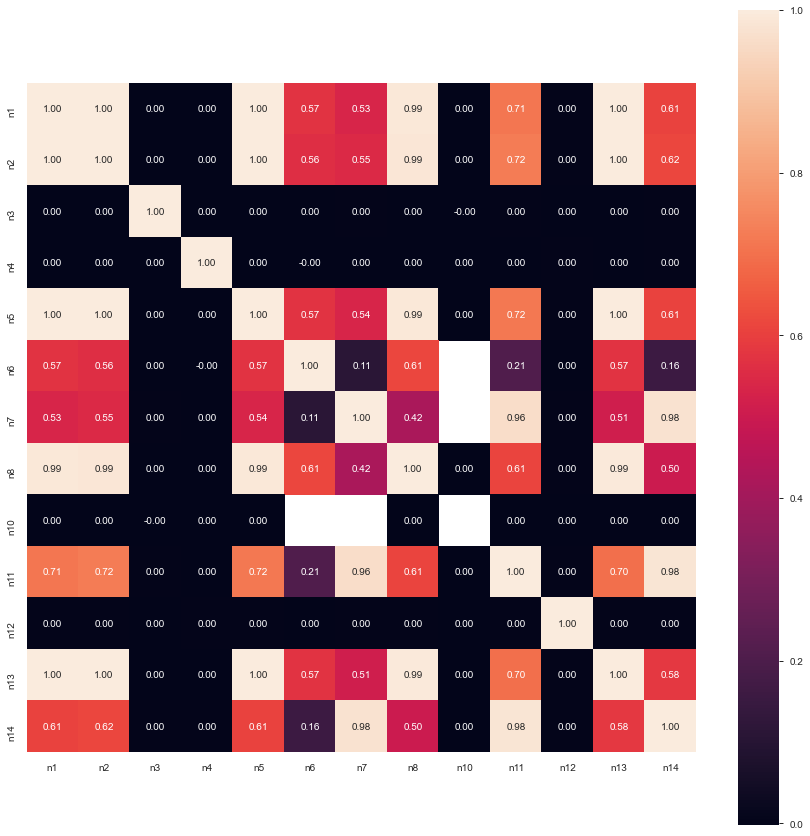

In [24]:
# Some variables can most likely be removed, so let's check for correlations of numerical columns now
fig, ax = matplotlib.pyplot.subplots(figsize=(15,15))
sns.heatmap(raw_plays.corr(),
            annot=True,
            fmt='.2f',            
            square=True,
            xticklabels=raw_plays.corr().columns,
            yticklabels=raw_plays.corr().columns)

I could potentially use this correlation and remove some variables directly with the information in the heatmap.

In [25]:
# In order to deal with the categorical columns, it is important to do something with the null values (i.e., NaNs)
# Therefore, I just convert them into the string 'Nan' because from earlier analysis there are too many rows with 
# NaNs to throw them away.
raw_plays_categorical_columns = raw_plays.filter(regex='^c\d$').columns
for col in list(raw_plays_categorical_columns):
    print("Filling NaNs in '{}'".format(col))
    raw_plays[col] = raw_plays[col].fillna("NaN")
    # raw_plays[col].fillna('NaN', inplace=True) # This should work, but does not (perhaps due to modin-pandas)

Filling NaNs in 'c1'
Filling NaNs in 'c2'
Filling NaNs in 'c3'
Filling NaNs in 'c4'
Filling NaNs in 'c6'


In [26]:
# Verify that NaNs have been taken care of
raw_plays.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 49707 entries, 0 to 49706
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   c1            49707 non-null  string 
 1   c2            49707 non-null  string 
 2   c3            49707 non-null  string 
 3   c4            49707 non-null  string 
 4   c6            49707 non-null  string 
 5   player_group  49707 non-null  string 
 6   n1            49707 non-null  float64
 7   n2            49707 non-null  float64
 8   n3            49707 non-null  float64
 9   n4            49707 non-null  float64
 10  n5            49707 non-null  float64
 11  n6            49707 non-null  float64
 12  n7            49707 non-null  float64
 13  n8            49707 non-null  float64
 14  n10           49707 non-null  float64
 15  n11           49707 non-null  float64
 16  n12           49707 non-null  float64
 17  n13           49707 non-null  float64
 18  n14           49707 n

In [27]:
# Encode the categorical columns to some value so that the correlation
label_encoder_dict = {}
raw_plays_categorical_columns = raw_plays.filter(regex='^c\d$').columns
raw_plays_player_group_columns = raw_plays.filter(like='player_group').columns

for col in list(raw_plays_categorical_columns) + list(raw_plays_player_group_columns):
    print("Label-enconding column '{}'".format(col))
    label_encoder = LabelEncoder()
    label_encoder_dict[col] = label_encoder.fit(raw_plays[col])
    raw_plays[col] = label_encoder_dict[col].transform(raw_plays[col])
    # raw_plays[col] = label_encoder.fit_transform(raw_plays[col])

Label-enconding column 'c1'
Label-enconding column 'c2'
Label-enconding column 'c3'
Label-enconding column 'c4'
Label-enconding column 'c6'
Label-enconding column 'player_group'


It looks like I could have achieved the same with `pd.get_dummies()` method (e.g., `pd.get_dummies(raw_plays[['c1', 'c2', 'c4', 'c6', 'player_group']])`).

Bummer...

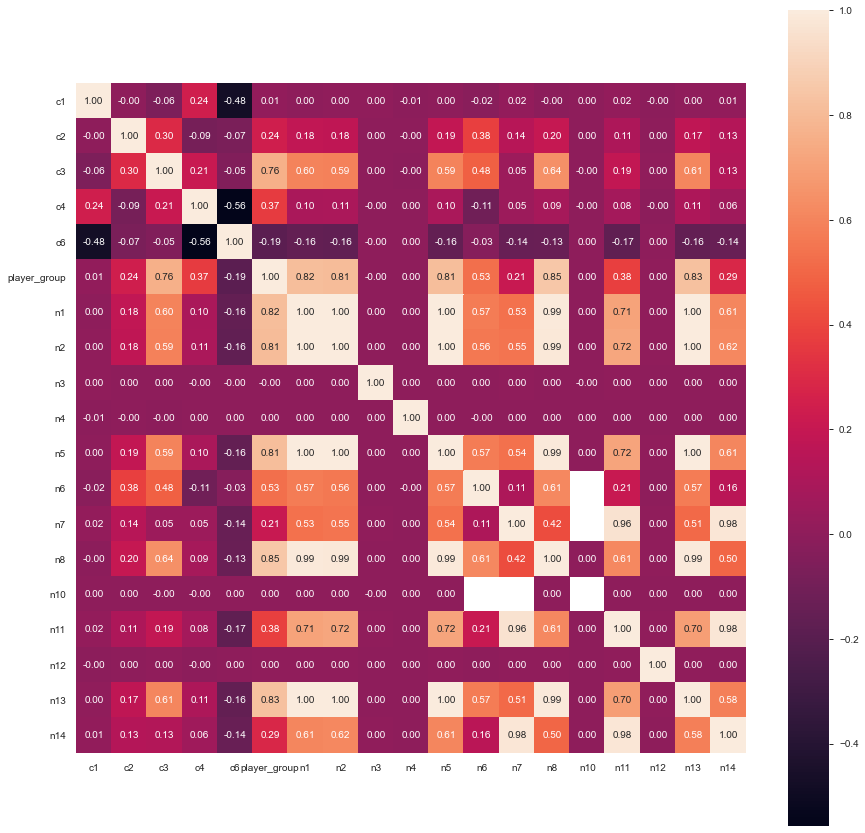

In [28]:
# Some variables can most likely be removed, so let's check for correlations between all columns
fig, ax = matplotlib.pyplot.subplots(figsize=(15,15))
sns.heatmap(raw_plays.corr(),
            annot=True,
            fmt='.2f',            
            square=True,
            xticklabels=raw_plays.corr().columns,
            yticklabels=raw_plays.corr().columns)

Interesting to see how the categorical columns are somewhat isolated from the numerical columns but they affect the correlations that exist between numerical columns.

In [29]:
# Let's drop what is not needed. Drop only perfect correlations for the sake of precision.
# Don't forget though...
# 'n1': engagement intensity (last 30 days before A/B test experiment)
# 'n13': engagement intensity (first 7 days of A/B test experiment)
# 'n14': monetization metric (first 7 days of A/B test experiment expenditure)

# While 'n13' and 'n1' are relevant engagement columns, they area about the same thing on a different period
# and their correlation shows that users are equally engaged before and after the reference test experiment date

# 'n13' == ('n1', 'n2', 'n5')
raw_plays.drop('n1', axis=1, inplace=True) # Drop 'n1'
raw_plays.drop('n2', axis=1, inplace=True) # Drop 'n2'
raw_plays.drop('n5', axis=1, inplace=True) # Drop 'n5'
# 'n13' == 'n8' ***
#raw_plays.drop('n8', axis=1, inplace=True) # Drop 'n8'
# 'n14' == 'n11'
raw_plays.drop('n11', axis=1, inplace=True) # Drop 'n11' 
# 'n14' == 'n7' ***
#raw_plays.drop('n7', axis=1, inplace=True) # Drop 'n7'

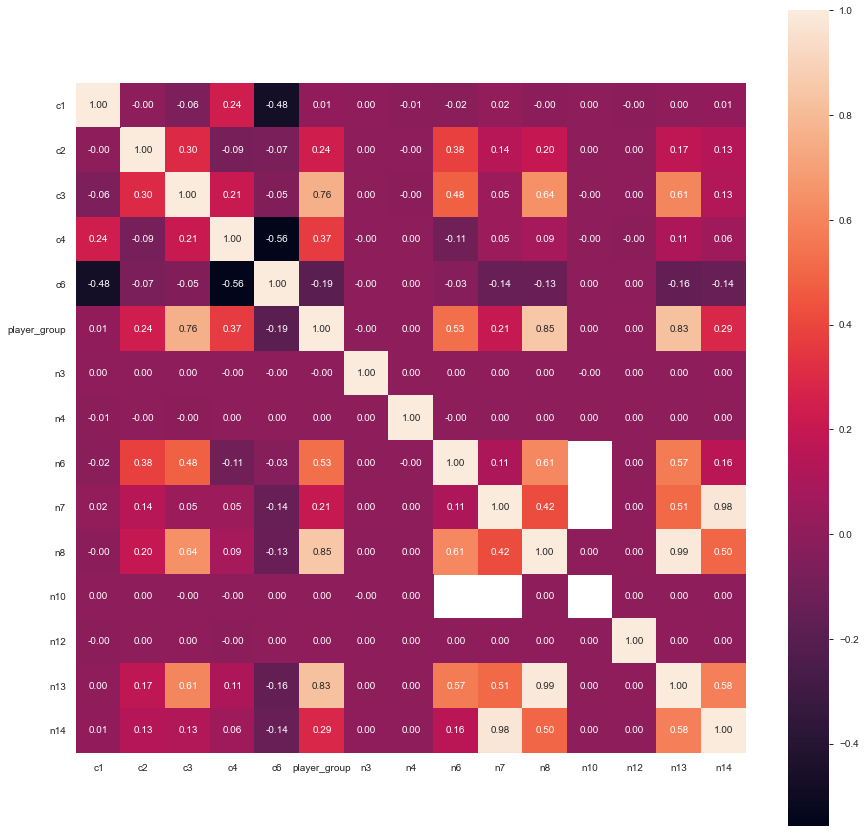

In [30]:
# Let's check again for correlations
fig, ax = matplotlib.pyplot.subplots(figsize=(15,15))
sns.heatmap(raw_plays.corr(),
            annot=True,
            fmt='.2f',            
            square=True,
            xticklabels=raw_plays.corr().columns,
            yticklabels=raw_plays.corr().columns)

And after dropping the data that is not needed, we can actually model something.

In [31]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "13.0.2" 2020-01-14; OpenJDK Runtime Environment (build 13.0.2+8); OpenJDK 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from /Users/billy/.local/share/virtualenvs/classifier-engagement-monetisation-moDQCH2S/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/dr/tw976mb12pg3vlpxjv4zfp3h0000gn/T/tmp4otulduj
  JVM stdout: /var/folders/dr/tw976mb12pg3vlpxjv4zfp3h0000gn/T/tmp4otulduj/h2o_billy_started_from_python.out
  JVM stderr: /var/folders/dr/tw976mb12pg3vlpxjv4zfp3h0000gn/T/tmp4otulduj/h2o_billy_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Stockholm
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,9 days
H2O_cluster_name:,H2O_from_python_billy_t47nhu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [32]:
# Decode the categorical columns to their original values. H2O will take care of them nicely.
for col in list(raw_plays_categorical_columns) + list(raw_plays_player_group_columns):
    print("Inverting the label-enconding column '{}'".format(col))
    raw_plays[col] = label_encoder_dict[col].inverse_transform(raw_plays[col])

Inverting the label-enconding column 'c1'
Inverting the label-enconding column 'c2'
Inverting the label-enconding column 'c3'
Inverting the label-enconding column 'c4'
Inverting the label-enconding column 'c6'
Inverting the label-enconding column 'player_group'


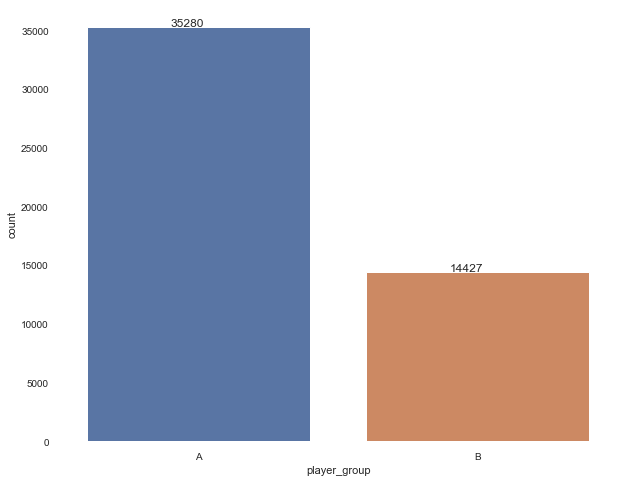

In [33]:
# Plot the count of 'player_group' per test (A or B)
fig, ax = matplotlib.pyplot.subplots(figsize=(10,8))
sns.set(style="darkgrid")
ax = sns.countplot(x="player_group", data=raw_plays._to_pandas())
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+50))

The dataset is imbalanced for classification purposes as the plot of the number of testers for each 'player_group' shows.

If nothing is done, the binary classification model may not perform well (it may end up being good, but mostly at classifying the majority class, A).

In order to solve this potential issue, one option is to downsample the majority class, A, to the same size of the minority class B. Another option is to upsample the minority class, B, to the size of the majority by 'cloning' data; and yet another option is to consider the weights of each class and take them into account when interpreting the results of the classifier, or embed these weights in the model.

In [34]:
# Define rebalancing of classes and create a balanced H2O dataframe. In our case, by downsampling.
count_test_A = raw_plays.player_group.value_counts().A
count_test_B = raw_plays.player_group.value_counts().B

if count_test_A > count_test_B:
    class_count = count_test_B
else:
    class_count = count_test_A
    
raw_plays_test_A = raw_plays[raw_plays.player_group == 'A'].sample(n=class_count)
raw_plays_test_B = raw_plays[raw_plays.player_group == 'B'].sample(n=class_count)
raw_plays_balanced = pd.concat([raw_plays_test_A, raw_plays_test_B], axis=0)

raw_plays_h2o_balanced = h2o.H2OFrame(raw_plays_balanced.copy()._to_pandas())

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [35]:
raw_plays_h2o_balanced.describe()

Rows:28854
Cols:15




,c1,c2,c3,c4,c6,player_group,n3,n4,n6,n7,n8,n10,n12,n13,n14
type,enum,enum,enum,enum,enum,enum,real,real,real,real,real,real,real,real,real
mins,,,,,,,0.0,-0.301107,-0.6621319999999999,4e-06,-1.0,-0.011209,0.0,-0.383024,1e-06
mean,,,,,,,251.79599018628144,15.38597445820346,1389517625.2601779,465403.01799276867,1077.7820633808474,2.037302136263874e+296,1.8064828128509,85.81520405455062,0.9199069991335677
maxs,,,,,,,9076.366024,31.0,7691516344.084719,32400422.446578003,3710.663537,5.018160974340511e+300,5062.155997999999,404.5425259999999,59.17568000000001
sigma,,,,,,,922.11449147214,11.419485708161819,1346432241.864023,2671463.0642952514,924.9913385372816,Infinity,35.87176475169901,80.39210992152078,3.6092661454838995
zeros,,,,,,,39,0,0,0,0,0,81,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,NaN,YW5kc,ZW4,YXBwb,ZWdhbF9zdHJp,A,13.456920000000002,8.411619,0.265474,0.17841700000000002,236.103061,0.041018,1.111646,16.613274,0.027841
1,VVM,YW5kc,ZW4,c2Ftc,KzA1OjMw,A,38.477411,0.899751,-0.151392,0.040051,58.990016,0.012802,1.028545,5.667479,0.008676999999999999
2,QlI,YW5kc,ZW4,YXBwb,NaN,A,21.081187,1.919769,0.739147,0.210136,264.12494399999997,0.045736,0.8074899999999999,18.395044,0.031121


In [36]:
# Create an imbalanced H2O dataframe (the original cleaned up dataset in fact)
raw_plays_h2o_imbalanced = h2o.H2OFrame(raw_plays.copy()._to_pandas())

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [37]:
raw_plays_h2o_imbalanced.describe()

Rows:49707
Cols:15




,c1,c2,c3,c4,c6,player_group,n3,n4,n6,n7,n8,n10,n12,n13,n14
type,enum,enum,enum,enum,enum,enum,real,real,real,real,real,real,real,real,real
mins,,,,,,,0.0,-0.301107,-0.68953,4e-06,-1.0,-0.011209,0.0,-0.383024,1e-06
mean,,,,,,,256.4573830894047,15.31780744693909,1070250843.8667227,270158.1856445925,752.6588166709302,1.1826164491874035e+296,1.599759898002299,58.97286938270268,0.551569018568817
maxs,,,,,,,9222.749526,31.0,7691516344.084719,32400422.446578003,3710.663537,5.018160974340511e+300,5062.155997999999,404.5425259999999,59.17568000000001
sigma,,,,,,,934.3153708646232,11.424838724312401,1319619862.7091756,2048272.3278195325,824.2122312329775,Infinity,28.014296980155635,70.18561468828926,2.7839299117432375
zeros,,,,,,,56,0,0,0,0,0,125,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,R0I,YW5kc,ZXM,NaN,LTA0OjAw,A,1.373772,4.777273,1513241033.988666,0.877958,563.317119,0.111096,0.270997,38.999087,0.073268
1,QVI,aW9z,cHQ,aHVhd,KzAzOjAw,B,13.83942,10.323625,703090784.144608,7.915538000000001,1059.667759,0.36095,0.349473,77.952363,0.185909
2,SVQ,aW9z,ZXM,NaN,LTA1OjAw,A,2.372309,4.691797,5050894415.663429,1.5732270000000002,700.112963,0.155331,0.140478,49.276629,0.097967


In [38]:
# Assign H2O dataframe of balanced/imbalanced classes to the main variable to use
#
raw_plays_h2o = raw_plays_h2o_balanced

In [39]:
raw_plays_h2o['player_group'] = raw_plays_h2o['player_group'].asfactor()

In [40]:
# Configure predictors columns and target
x = raw_plays_h2o.columns
y = 'player_group'
x.remove(y)

In [41]:
# Split data... right? :)
plays_train, plays_test, plays_validation = raw_plays_h2o.split_frame(ratios=[.7, .15])

In [42]:
# Try random forest first...
ignored_columns = ['c1',
                   'c2',
                   'c3',
                   'c4',
                   'c6']

rfe_model = H2ORandomForestEstimator(ntrees=100,
                                     max_depth=25,
                                     nfolds=10,
                                     distribution="bernoulli",
                                     binomial_double_trees=True,
                                     #weights_column="weight",
                                     #ignored_columns=ignored_columns,
                                     calibrate_model=True,
                                     calibration_frame=plays_validation,
                                     balance_classes=False,
                                     seed=random_seed)
rfe_model.train(x=x,
                y=y,
                training_frame=plays_train,
                validation_frame=plays_validation)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [43]:
# Let's check the random forest model performance
rfe_performance = rfe_model.model_performance(test_data=plays_test)
print(rfe_performance)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 1.9589988017756344e-06
RMSE: 0.0013996423835307484
LogLoss: 0.00013577893447902007
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9309038061692245: 


,,A,B,Error,Rate
0,A,2128.0,0.0,0.0,(0.0/2128.0)
1,B,0.0,2208.0,0.0,(0.0/2208.0)
2,Total,2128.0,2208.0,0.0,(0.0/4336.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.930904,1.000000,10.0
1,max f2,0.930904,1.000000,10.0
2,max f0point5,0.930904,1.000000,10.0
3,max accuracy,0.930904,1.000000,10.0
4,max precision,1.000000,1.000000,0.0
5,max recall,0.930904,1.000000,10.0
6,max specificity,1.000000,1.000000,0.0
7,max absolute_mcc,0.930904,1.000000,10.0
8,max min_per_class_accuracy,0.930904,1.000000,10.0
9,max mean_per_class_accuracy,0.930904,1.000000,10.0



Gains/Lift Table: Avg response rate: 50.92 %, avg score: 50.92 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.500231,1.000000,1.963768,1.963768,1.000000,1.00000,1.000000,1.000000,0.982337,0.982337,96.376812,96.376812
1,,2,1.000000,0.000003,0.035342,1.000000,0.017997,0.01795,0.509225,0.509202,0.017663,1.000000,-96.465761,0.000000


The confusion matrix is quite revealing of the performance at the max f1 at the threshold. Other metrics are available like RMSE and log loss.

I am not sure why the model is 'so' perfect but I can speculate that the correlation of the target column with some of the numerical columns is a hint for that. One could question that this is a downsampled balanced dataset but the uniformity distribution of all numerical columns means that the downsampling will likely not affectt much. In fact, even with the imbalanced dataset the results are pretty much the same.

In [44]:
# Some sample prediction with the random forest model
rfe_model.predict(plays_test.drop('player_group'))

drf prediction progress: |████████████████████████████████████████████████| 100%


predict,A,B,cal_A,cal_B
A,0.999997,2.9656e-06,1,2.4638e-08
A,0.999997,2.9656e-06,1,2.4638e-08
A,0.999997,2.9656e-06,1,2.4638e-08
A,0.999997,2.9656e-06,1,2.4638e-08
A,0.999997,2.9656e-06,1,2.4638e-08
A,0.999997,2.9656e-06,1,2.4638e-08
A,0.999997,2.9656e-06,1,2.4638e-08
A,0.999997,2.9656e-06,1,2.4638e-08
A,0.999997,2.9656e-06,1,2.4638e-08
A,0.999997,2.9656e-06,1,2.4638e-08


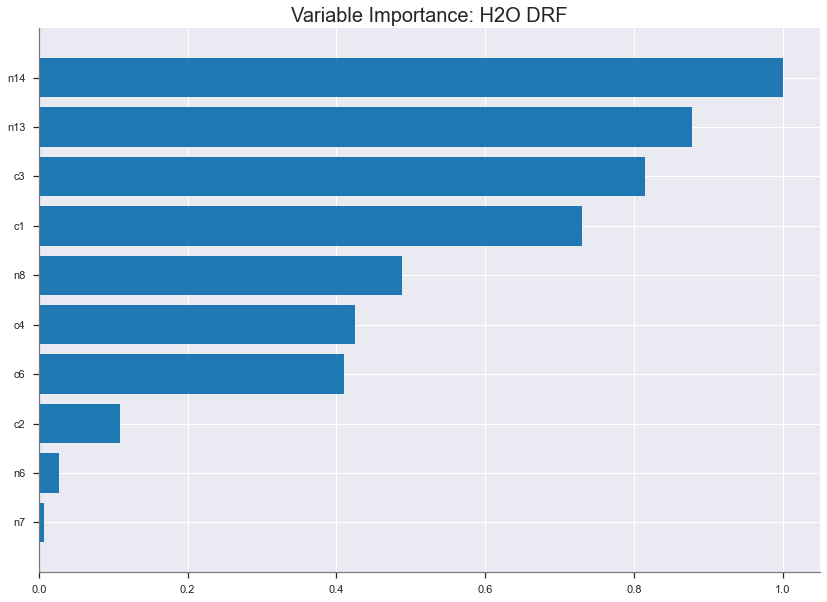

In [45]:
# Let's plot the importance of the data for the random forest model.
#rfe_model.varimp(use_pandas=True)
rfe_model.varimp_plot()

The above plot confirms the heatmap of correlations. And maybe we don't really need a fancy model for this problem and rather some simple function after all.

In [46]:
# XGBoost hyperparameters
xgboost_hyperparameters = {'ntrees': [10, 1000, 1],
                           'learn_rate':[0.0001, 0.2, 0.0001],
                           'max_depth': [1, 20, 1],
                           'sample_rate': [0.5, 1.0, 0.0001],
                           'col_sample_rate': [0.2, 1.0, 0.0001]}

# Search criteria
xgboost_search_criteria = {'strategy': 'RandomDiscrete',
                           'max_models': 36,
                           'seed': random_seed}

# Train and validate a random grid of GBMs
xgboost_grid = H2OGridSearch(model=H2OXGBoostEstimator,
                             grid_id='xgboost_grid',
                             hyper_params=xgboost_hyperparameters,
                             search_criteria=xgboost_search_criteria)

xgboost_grid.train(x=x,
                   y=y,
                   training_frame=plays_train,
                   validation_frame=plays_validation)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [47]:
# Get the grid results, sorted by validation AUC
xgboost_grid_performance = xgboost_grid.get_grid(sort_by='auc',
                                                 decreasing=True)
xgboost_grid_performance

# Grab the top XGBoost model, chosen by validation AUC
best_xgboost_model = xgboost_grid_performance.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_xgboost_performance = best_xgboost_model.model_performance(plays_test)

best_xgboost_performance


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2046972040576512
RMSE: 0.45243475116048637
LogLoss: 0.6022736484297834
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5475651025772095: 


,,A,B,Error,Rate
0,A,2128.0,0.0,0.0,(0.0/2128.0)
1,B,0.0,2208.0,0.0,(0.0/2208.0)
2,Total,2128.0,2208.0,0.0,(0.0/4336.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.547565,1.0,0.0
1,max f2,0.547565,1.0,0.0
2,max f0point5,0.547565,1.0,0.0
3,max accuracy,0.547565,1.0,0.0
4,max precision,0.547565,1.0,0.0
5,max recall,0.547565,1.0,0.0
6,max specificity,0.547565,1.0,0.0
7,max absolute_mcc,0.547565,1.0,0.0
8,max min_per_class_accuracy,0.547565,1.0,0.0
9,max mean_per_class_accuracy,0.547565,1.0,0.0



Gains/Lift Table: Avg response rate: 50.92 %, avg score: 50.09 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.509225,0.547565,1.963768,1.963768,1.0,0.547565,1.000000,0.547565,1.0,1.0,96.376812,96.376812
1,,2,1.000000,0.452435,0.000000,1.000000,0.0,0.452435,0.509225,0.500877,0.0,1.0,-100.000000,0.000000


### Question 4

Please serve your trained model in a way so that prediction/recommendation for other players can be easily carried out.

##### Some answer

H2O provides a way, and guidance, on how to make an H2O (trained) model into production: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/productionizing.html

In a nutshell it converts the model into a Java artifact that can be used for further queries at some deployment. While not an expert myself on REST APIs with Java, it seems that the idea would be to set up some container (e.g., Docker) that provides a REST API interface which in turn communicates with the MOJO artifact generated with H2O.